## Approximating the Output of a Small Language Model

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide
import gc
import json
import math
import os
from pathlib import Path
from typing import Dict, List, Optional, Iterable, Sequence, Tuple, Type

In [ ]:
# | hide
# | output: false
from fastcore.test import *
from IPython import get_ipython
from IPython.display import display, HTML, Image
from manim import *
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import torch
from torch.nn import functional as F
from tqdm.auto import tqdm

Manim Community v0.17.3

In [ ]:
# | hide

from transformer_experiments.common.substring_generator import all_unique_substrings
from transformer_experiments.common.text_analysis import (
    build_next_token_map,
    SubstringFrequencyAnalysis,
    top_nonzero_tokens
)
from transformer_experiments.common.utils import aggregate_by_string_key, DataWrapper
from transformer_experiments.dataset_split import split_text_dataset
from transformer_experiments.datasets.tinyshakespeare import (
    TinyShakespeareDataSet,
)
from transformer_experiments.environments import get_environment
from transformer_experiments.experiments.cosine_sims import filter_on_prefiltered_results
from transformer_experiments.models.transformer import (
    n_embed,
    n_layer,
    TransformerLanguageModel
)
from transformer_experiments.models.transformer_helpers import (
    unsqueeze_emb,
    EncodingHelpers,
    LogitsWrapper,
    TransformerAccessors
)
from transformer_experiments.trained_models.tinyshakespeare_transformer import (
    create_model_and_tokenizer
)
from transformer_experiments.experiments.block_internals import (
    BlockInternalsAccessors,
    BlockInternalsExperiment,
    BatchedBlockInternalsExperiment,
    BlockInternalsAnalysis,
)
from transformer_experiments.experiments.logit_lens import LogitLens

In [ ]:
#| hide
environment = get_environment()
print(f"environment is {environment.name}")

environment is local_mac


In [ ]:
# | echo: false
def render_final_frame(scene_class: Type, quality: str = 'ql'):
    get_ipython().run_cell_magic(
        'manim',
        f'-v WARNING --progress_bar None -{quality} -s --disable_caching {scene_class.__name__}',
        '# dummy',
    )

In the transformer architecture, every block contains two significant sub-components: a multi-head self-attention layer and a feed-forward network. A lot of words have been written about multi-head attention in tutorials and even the original paper. On the feed-forward network, comparatively little has been said because, it seems, comparatively little is known: 

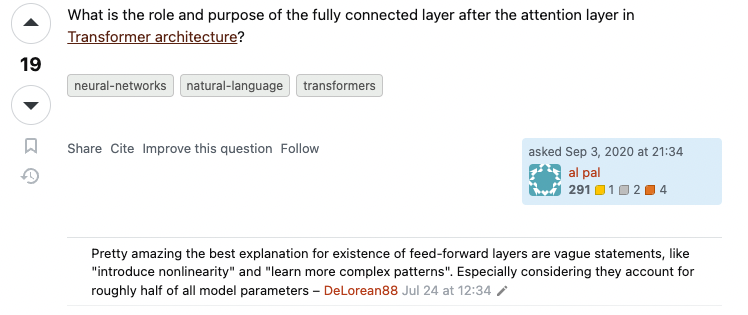

In [ ]:
#| echo: false
display(Image('./static_images/so_screenshot_on_ffwd.png'))

In [ ]:
#| echo: false
display(HTML('<p style="text-align: center;">Screenshot from <a href="https://stats.stackexchange.com/q/485910">https://stats.stackexchange.com/q/485910</a></p>'))

We know the feed-forward network transforms the output of the current block's attention layer before it becomes the input into the next block (or the final projection layer of the model). But we don't know how to interpret those transformations in terms of human-understandable concepts. 

I trained a small (10 million parameter) transformer and then spent the last several months poking at it to see what I could learn. I found two interesting things:

1. The **outputs of the feed-forward network cluster in human-interpretable ways** i.e. the prompts that produce similar feed-forward network outputs have recognizable similar features. 
2. I can approximate the output of the transformer for a given prompt if I know what strings in the training corpus produce similar feed-forward network outputs to the prompt. Specifically, **the output of the transformer approximates a linear combination of training corpus next token probability distributions for the strings that produce similar feed-forward network outputs**. 

There's a lot of nuance to "similar", "approximate", and, "linear combination", which I'll explain in this article. But, at least for the one transformer I trained, looking at the feed-forward network outputs tells us something about what the transformer is doing. 

## The Model and Setup

### Disclaimer

I want to start by saying upfront: the code for the model I trained isn't mine. It came from [Andrej Karpathy](https://karpathy.ai/)'s excellent video, [Let's build GPT: from scratch, in code, spelled out](https://www.youtube.com/watch?v=kCc8FmEb1nY). In that video, he starts from a blank Jupyter notebook and, just under 2 hours later, ends with a functional transformer model (it's one of the best explanatory videos I've ever seen and highly recommend it).

I typed in the code by copying what I saw on the screen as I watched the video. For things that weren't clear onscreen, I referenced the [GitHub repo for the video](https://github.com/karpathy/ng-video-lecture) and the [nanoGPT repo](https://github.com/karpathy/nanoGPT). After getting it working, I made only minor changes to make it work with the rest of the code in/structure of [my repository](https://github.com/spather/transformer-experiments), resulting in [this implementation](https://github.com/spather/transformer-experiments/blob/master/nbs/models/transformer.ipynb). In summary: the core language model is Andrej Karpathy's work, not mine. The analysis and all the supporting code behind it is mine. I was of course inspired by many others and I'll cite their work in the relevant places. 

### Model Details
The model is a 6-block, decoder-only [transformer](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)):


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ts = TinyShakespeareDataSet(cache_file=environment.code_root / 'nbs/artifacts/input.txt')
m, tokenizer = create_model_and_tokenizer(
    saved_model_filename=environment.code_root / 'nbs/artifacts/shakespeare-20231112.pt',
    dataset=ts,
    device=device,
)
encoding_helpers = EncodingHelpers(tokenizer, device)

In [ ]:
# | code-fold: true
# | code-summary: Drawing code for architecture diagram

class ArchDiagram(Scene):
    def construct(self):
        prompt = 'ROMEO:'
        tokens = MobjectTable(
            [[Text(f'{t}', font='Arial') for t in tokenizer.encode(prompt)]],
            include_outer_lines=True,
        ).scale(0.25)
        tokens = VGroup(
            Text('Input Tokens', font='Arial').scale(0.4).next_to(tokens, UP, buff=0.1),
            tokens,
        )

        token_emb = m.token_embedding_table(encoding_helpers.tokenize_string(prompt))
        token_emb = MobjectTable(
            [[Text(f'{x:.1f}', font='Arial') for x in token_emb[0, :, row]] for row in range(0, 2)]
            + [[Text('...', font='Arial').rotate(PI/2) for _ in prompt]]
            + [
                [Text(f'{x:.1f}', font='Arial') for x in token_emb[0, :, row]]
                for row in range(n_embed - 2, n_embed)
            ],
            include_outer_lines=True,
        ).scale(0.25)

        pos_emb = m.position_embedding_table(
            torch.arange(0, len(prompt), device=device)
        )
        pos_emb = MobjectTable(
            [[Text(f'{x:.1f}', font='Arial') for x in pos_emb[:, row]] for row in range(0, 2)]
            + [[Text('...', font='Arial').rotate(PI/2) for _ in prompt]]
            + [
                [Text(f'{x:.1f}', font='Arial') for x in pos_emb[:, row]]
                for row in range(n_embed - 2, n_embed)
            ],
            include_outer_lines=True,
        ).scale(0.25)

        embs = VGroup(
            token_emb,
            pos_emb,
        ).arrange(RIGHT, buff=2)

        embs = VGroup(
            tokens,
            embs,
        ).arrange(DOWN, buff=0.5)

        emb_labels = VGroup(
            Text('Token Embeddings', font='Arial')
            .scale(0.4)
            .next_to(token_emb, DOWN, buff=0.1)
            .align_to(token_emb, LEFT),
            Text('Position Embeddings', font='Arial')
            .scale(0.4)
            .next_to(pos_emb, DOWN, buff=0.1)
            .align_to(pos_emb, RIGHT),
        )

        blocks1_2 = [Rectangle(height=0.4, width=3) for _ in range(2)]
        vert_ellipsis = VGroup(
            *[Circle(radius=0.025, color=WHITE) for _ in range(3)],
        ).arrange(direction=DOWN, buff=0.1)
        block6 = Rectangle(height=0.4, width=3)
        blocks = VGroup(
            *blocks1_2,
            vert_ellipsis,
            block6,
        ).arrange(DOWN, buff=0.1)

        empty_rect = Rectangle(height=0.25, width=3, color=BLACK)

        out_blocks = [Rectangle(height=0.4, width=3) for _ in range(3)]

        arch = VGroup(
            embs,
            emb_labels,
            blocks,
            empty_rect,
            *out_blocks,
            empty_rect.copy()
        ).arrange(DOWN, buff=0.1)
        self.add(arch)

        # Add annotations

        # Lines and arrows between tokens and embedding tables
        left_line = Line(start=tokens[1].get_left(), end=(tokens[1].get_left() * [0., 1., 0.]) + (token_emb.get_center() * [1., 0., 0.]))
        self.add(left_line)
        left_arrow_down = Arrow(max_tip_length_to_length_ratio=0.15)
        left_arrow_down.put_start_and_end_on(
            start=left_line.get_left(),
            end=left_line.get_left() * [1., 0., 0.] + token_emb.get_top() * [0., 1., 0.],
        )
        self.add(left_arrow_down)

        right_line = Line(start=tokens[1].get_right(), end=(tokens[1].get_right() * [0., 1., 0.]) + (pos_emb.get_center() * [1., 0., 0.]))
        self.add(right_line)
        right_arrow_down = Arrow(max_tip_length_to_length_ratio=0.15)
        right_arrow_down.put_start_and_end_on(
            start=right_line.get_right(),
            end=right_line.get_right() * [1., 0., 0.] + pos_emb.get_top() * [0., 1., 0.],
        )
        self.add(right_arrow_down)

        # Circle with the plus between the embedding tables
        circle = (
            Circle(radius=0.4, color=WHITE)
            .move_to((token_emb.get_right() + pos_emb.get_left()) / 2)
        )
        self.add(circle)
        plus = Text('+', font='Arial').move_to(circle.get_center())
        self.add(plus)

        # Arrows from embedding tables to circled plus
        right_arrow = Arrow(max_tip_length_to_length_ratio=0.15)
        right_arrow.put_start_and_end_on(
            start=token_emb.get_right(),
            end=circle.get_left()
        )
        self.add(right_arrow)

        left_arrow = Arrow(max_tip_length_to_length_ratio=0.15)
        left_arrow.put_start_and_end_on(
            start=pos_emb.get_left(),
            end=circle.get_right()
        )
        self.add(left_arrow)

        # Arrow down to the first block
        down_arrow = Arrow(max_tip_length_to_length_ratio=0.15)
        down_arrow.put_start_and_end_on(
            start=circle.get_bottom(),
            end=blocks1_2[0].get_top(),
        )
        self.add(down_arrow)

        # Block labels
        blocks1_2_labels = [Text(f'Block {b+1}', font='Arial').move_to(blocks1_2[b].get_center()).scale(0.4) for b in range(2)]
        self.add(*blocks1_2_labels)
        block6_label = Text('Block 6', font='Arial').move_to(block6.get_center()).scale(0.4)
        self.add(block6_label)

        # Output blocks labels
        labels = ['Layer Norm', 'Linear', 'Softmax']
        out_block_labels = [Text(f'{l}', font='Arial').move_to(out_blocks[b].get_center()).scale(0.4) for b, l in enumerate(labels)]
        self.add(*out_block_labels)

        # Arrow between last block and output blocks
        out_block_arrow = Arrow(max_tip_length_to_length_ratio=0.08)
        out_block_arrow.put_start_and_end_on(
            start=block6.get_bottom(),
            end=out_blocks[0].get_top(),
        )
        self.add(out_block_arrow)

        # Text at the bottom
        out_prob_text = Text('Output Probabilities', font='Arial').scale(0.4).next_to(out_blocks[-1], DOWN, buff=0.5)
        self.add(out_prob_text)

        # Arrow between softmax and output probs
        out_prob_arrow = Arrow(max_tip_length_to_length_ratio=0.08)
        out_prob_arrow.put_start_and_end_on(
            start=out_blocks[-1].get_bottom(),
            end=out_prob_text.get_top(),
        )
        self.add(out_prob_arrow)

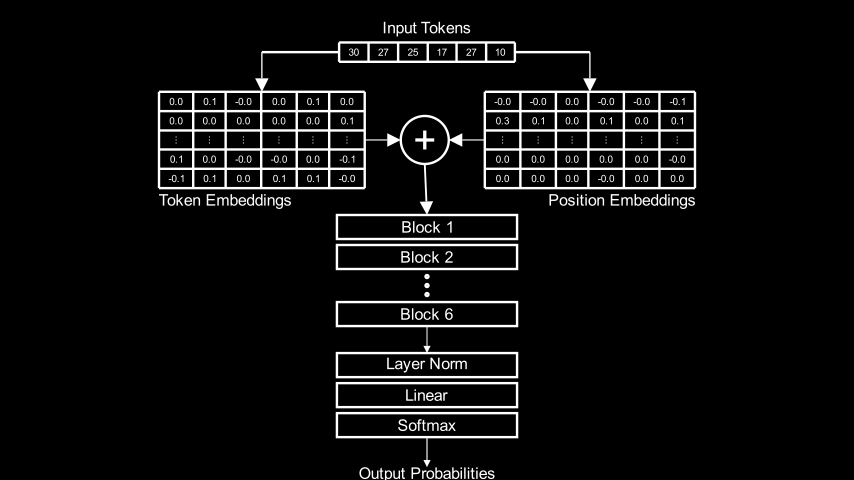

In [ ]:
# | echo: false
render_final_frame(ArchDiagram)

It’s trained on the [TinyShakespeare data set](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt) which contains 40,000 lines of Shakespeare’s plays. 

After about an hour of training on an A100 GPU, it is able to produce reasonable-looking fake Shakespearean text. 

Let’s spin it up and look at it in action. Given a prompt, the model generates tokens that it thinks should follow. Let's look at an example, using the text `ROMEO:` as the prompt:

In [ ]:
torch.manual_seed(2321) # Keep the output deterministic across runs
prompt = 'ROMEO:'
tokens = encoding_helpers.tokenize_string(prompt)
print(tokenizer.decode(m.generate(tokens, max_new_tokens=500)[0].tolist()))

ROMEO:
If thou wilt triumphant be virtue, and since from any
bold virtue that is made a bawd of earth, then the
duke desires of patience and perish:
take up the other husband, dislike his tent
back.

First Citizen:
Ourself goes, go back: you have no consul, but the disguised gods.

Second Citizen:
We choose him in the world, he did runk itself.

First Citizen:
Sir, I am I a man changed him and thriving, I have heard the
king.

CORIOLANUS:
Consider him!

AUFIDIUS:
Most gracious irice, and you must danc


It's not Shakespeare but structurally, it's plausible Shakespeare. It looks like the script for a play, the language sounds archaic, the character names/titles come from real Shakespeare plays. Most of the words are English words. Punctuation and capitalization are mostly sensible. Clearly, none of the text actually makes sense, but still, it's not bad for an hour of training. 

The **tokens in the model are characters**, not words. Given a prompt, the model predicts a probability distribution for the next character. For example, given the prompt `'my most gr`, these are the probabilities the model predicts for the next token:

In [ ]:
prompt = 'my most gr'
tokens = encoding_helpers.tokenize_string(prompt)
logits, _ = m(tokens)
logits = LogitsWrapper(logits.detach(), tokenizer)
for token, prob in logits.topk_tokens(k=10)[0][-1]:
    print(f'{repr(token)} {prob:.3f}')

'a' 0.819
'e' 0.081
'i' 0.059
'o' 0.036
'u' 0.004
'y' 0.001
'w' 0.000
'r' 0.000
'g' 0.000
's' 0.000



Other specifics of note:

* Vocabulary size: 65 (just the unique characters in the TinyShakespeare dataset)
* Embedding size (`n_embed`): 384
* Number of transformer blocks (`n_layer`): 6
* Number of attention heads (`n_head`): 6
* Context window size (`block_size`): 256

### Transformer Block Structure

The following PyTorch module implements the structure and logic of each block in the transformer: 

```python
class Block(nn.Module):
    """One transformer block"""

    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1  = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)


    def forward(self, x):
        x = x + self.sa(self.ln1(x)) # The `x +` part is a skip connection
        x = x + self.ffwd(self.ln2(x)) # The `x +` part is a skip connection

        return x
```

As a diagram:

In [ ]:
# | code-fold: true
# | code-summary: Drawing code for block internals architecture diagram


class BlockArchDiagram(Scene):
    def construct(self):
        input_emb = Rectangle(height=0.4, width=3)
        input_emb_label = (
            Text('Block Input', font='Arial').move_to(input_emb.get_center()).scale(0.4)
        )
        input_emb = VGroup(input_emb, input_emb_label)

        ln1 = Rectangle(height=0.4, width=3)
        ln1_label = Text('Layer Norm', font='Arial').move_to(ln1.get_center()).scale(0.4)
        ln1 = VGroup(ln1, ln1_label)

        sa = Rectangle(height=0.4, width=3)
        sa_label = Text('Multi-Head Self-Attention', font='Arial').move_to(sa.get_center()).scale(0.4)
        sa = VGroup(sa, sa_label)

        stack1 = VGroup(ln1, sa).arrange(DOWN, buff=0.5)

        first_plus = self.circled_plus(radius=0.3)

        ln2 = Rectangle(height=0.4, width=3)
        ln2_label = Text('Layer Norm', font='Arial').move_to(ln2.get_center()).scale(0.4)
        ln2 = VGroup(ln2, ln2_label)

        ffwd = Rectangle(height=0.4, width=3)
        ffwd_label = Text('Feed Forward', font='Arial').move_to(ffwd.get_center()).scale(0.4)
        ffwd = VGroup(ffwd, ffwd_label)

        stack2 = VGroup(ln2, ffwd).arrange(DOWN, buff=0.5)

        empty_rect = Rectangle(height=0.2, width=3, color=BLACK)

        second_plus = self.circled_plus(radius=0.3)

        self.add(
            VGroup(
                empty_rect,
                input_emb,
                stack1,
                first_plus,
                empty_rect.copy(),
                stack2,
                second_plus,
                empty_rect.copy(),
            ).arrange(DOWN, buff=0.5)
        )
        stack1.shift(LEFT * 2)
        stack2.shift(LEFT * 2)

        # Add annotations

        arrow_stroke_width = 2.0
        # Arrow from input emb to ln1
        self.add(
            self.arrow_via_points(
                [
                    input_emb.get_left(),
                    ln1.get_top() * [1.0, 0.0, 0.0]
                    + input_emb.get_left() * [0.0, 1.0, 0.0],
                    ln1.get_top(),
                ],
                stroke_width=arrow_stroke_width,
            )
        )

        # Arrow from ln1 to sa
        self.add(
            self.arrow_via_points(
                [
                    ln1.get_bottom(),
                    sa.get_top(),
                ],
                stroke_width=2 * arrow_stroke_width,
            )
        )

        # Arrow from sa to first plus
        self.add(
            self.arrow_via_points(
                [
                    sa.get_bottom(),
                    sa.get_bottom() * [1.0, 0.0, 0.0]
                    + first_plus.get_left() * [0.0, 1.0, 0.0],
                    first_plus.get_left(),
                ],
                stroke_width=arrow_stroke_width,
            )
        )

        # Arrow from input emb to circled plus
        self.add(
            self.arrow_via_points(
                [
                    input_emb.get_right(),
                    ln1.get_top() * [-1.0, 0.0, 0.0]
                    + input_emb.get_right() * [0.0, 1.0, 0.0],
                    ln1.get_top() * [-1.0, 0.0, 0.0]
                    + first_plus.get_right() * [0.0, 1.0, 0.0],
                    first_plus.get_right(),
                ],
                stroke_width=arrow_stroke_width,
            )
        )

        # Arrow from first plus to ln2
        self.add(
            self.arrow_via_points(
                [
                    first_plus.get_bottom(),
                    first_plus.get_bottom()
                    + (ln2.get_top() - first_plus.get_bottom()) * [0.0, 0.5, 0.0],
                    ln2.get_top()
                    - (ln2.get_top() - first_plus.get_bottom()) * [0.0, 0.5, 0.0],
                    ln2.get_top(),
                ],
                stroke_width=arrow_stroke_width,
            )
        )

        # Arrow from ln2 to ffwd
        ln2_ffwd_arrow = Arrow(max_tip_length_to_length_ratio=0.08)
        ln2_ffwd_arrow.put_start_and_end_on(
            start=ln2.get_bottom(),
            end=ffwd.get_top(),
        )
        self.add(ln2_ffwd_arrow)

        # Arrow from ffwd to second plus
        self.add(
            self.arrow_via_points(
                [
                    ffwd.get_bottom(),
                    ffwd.get_bottom() * [1.0, 0.0, 0.0]
                    + second_plus.get_left() * [0.0, 1.0, 0.0],
                    second_plus.get_left(),
                ],
                stroke_width=arrow_stroke_width,
            )
        )

        # Arrow from first plus to second plus
        self.add(
            self.arrow_via_points(
                [
                    first_plus.get_bottom()
                    + (ln2.get_top() - first_plus.get_bottom()) * [0.0, 0.5, 0.0],
                    second_plus.get_top(),
                ],
                stroke_width=2 * arrow_stroke_width,
            )
        )

        # Arrow from second plus to output
        self.add(
            self.arrow_via_points(
                [
                    second_plus.get_bottom(),
                    second_plus.get_bottom() + DOWN * 0.4,
                ],
                stroke_width=2 * arrow_stroke_width,
            )
        )

    def arrow_via_points(self, points: Iterable[np.ndarray], stroke_width: float = 2.0):
        assert (
            len(points) >= 2
        ), 'Must provide at least two points to draw an arrow between'

        lines = VGroup()
        if len(points) > 2:
            # Draw lines up to the the second to last point
            lines.add(
                *[
                    Line(start=points[i], end=points[i + 1], stroke_width=stroke_width)
                    for i in range(len(points) - 1)
                ]
            )

        # Draw the final arrow
        arrow_length = np.linalg.norm(points[-1] - points[-2])
        arrow = Arrow(
            max_tip_length_to_length_ratio=0.08,
            max_stroke_width_to_length_ratio=stroke_width / arrow_length,
        )
        arrow.put_start_and_end_on(
            start=points[-2],
            end=points[-1],
        )
        arrow.set_stroke(
            width=stroke_width / 2
        )  # I don't know why but to get the width right I need to divide by 2
        lines.add(arrow)
        return lines

    def circled_plus(self, radius: float = 0.4):
        circle = Circle(radius=radius, color=WHITE)
        plus = Text('+', font='Arial').move_to(circle.get_center())
        return VGroup(circle, plus)

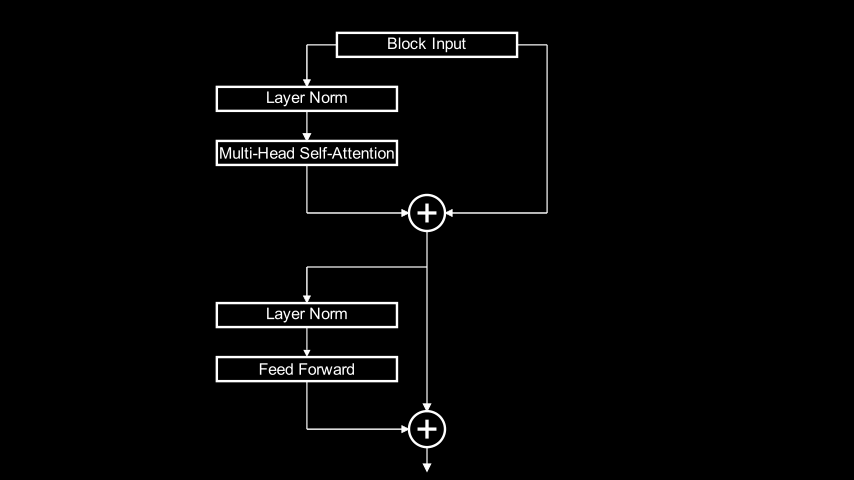

In [ ]:
# | echo: false
render_final_frame(BlockArchDiagram)

The feed-forward networks across the 6 blocks of the transformer comprise over 65% of the total trainable parameters:

In [ ]:
all_trainable_params = [p for p in m.parameters() if p.requires_grad]
n_all_trainable_params = sum([np.prod(p.size()) for p in all_trainable_params])

ffwd_trainable_params = [
    p
    for block_idx in range(n_layer)
    for p in m.blocks[block_idx].ffwd.parameters()
    if p.requires_grad
]
n_ffwd_trainable_params = sum([np.prod(p.size()) for p in ffwd_trainable_params])

print(
    f"{n_ffwd_trainable_params:,} ffwd params out of {n_all_trainable_params:,} total params ({n_ffwd_trainable_params / n_all_trainable_params:.2%})"
)

7,089,408 ffwd params out of 10,788,929 total params (65.71%)


I'm not going to go too much further into the details of the model architecture. If you want to learn more, I highly recommend watching [Andrej's video](https://www.youtube.com/watch?v=kCc8FmEb1nY).

## Feed-forward Network Outputs Cluster

If we run a large number of prompts through the model and save the outputs of the feed-forward network in each block, we'll see that the feed-forward outputs cluster in interpretable ways. Let's look at this in action.

To do this analysis, we'll use prompts of length 10. The model supports a context window of up to 256 tokens (characters), but smaller prompts show the effect and are faster to work with. 

First, let's get a sample of 20,000 length 10 strings from the training corpus:

In [ ]:
# Get all the unique substrings of length 10 from the text
strings10 = all_unique_substrings(text=ts.text, substring_length=10)

In [ ]:
torch.manual_seed(1442)
indices = torch.randperm(len(strings10), dtype=torch.long)
n_samples = 20000
sample_strings = [strings10[i.item()] for i in indices[:n_samples]]
sample_strings[:5]

['straying f', 'es out\nMos', 'PTISTA:\nSh', "'t it had;", 'y from us,']

Next, we run them through the model. To do this, I'm using [helper functions I wrote](https://github.com/spather/transformer-experiments/blob/master/nbs/models/transformer-helpers.ipynb) to embed the 20,000 strings and then send them through the model with the necessary hooks attached to extract the intermediate values.

In [ ]:
# Tokenize the strings
tokens = encoding_helpers.tokenize_strings(sample_strings)

# Embed the tokens
accessors = TransformerAccessors(m, device)
embeddings = accessors.embed_tokens(tokens)

# Run them through the model with hooks attached that let us look at
# intermediate values
_, io_accessors = accessors.run_model(embeddings)

The hooks in `TransformerAccessors.run_model()` save lots of potentially interesting intermediate values. We're just interested in the feed-forward network outputs for each block, for just the last token, so we'll save those off and then free up the memory used by the other stuff we're not looking at. 

In [ ]:
# Grab the outputs of the ffwd networks at each layer
ffwd_outs = []
for block_idx in range(n_layer):
    ffwd_outs.append(io_accessors[block_idx].output('ffwd')[:, -1, :].clone())

In [ ]:
# Free up some memory
del io_accessors
_ = gc.collect()

I used the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) to find the optimal number of clusters. For brevity, I'm not including that analysis here. 

  0%|          | 0/59 [00:00<?, ?it/s]

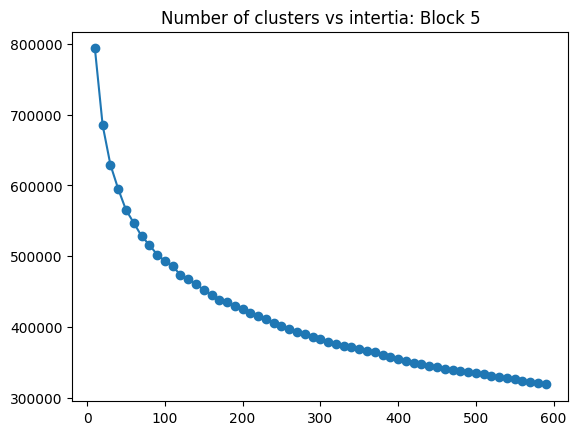

In [ ]:
#| hide
block_idx = 5
inertias = []
ks = range(10, 600, 10)
for k in tqdm(ks):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(ffwd_outs[block_idx])
    inertias.append(kmeans.inertia_)

plt.plot(ks, inertias, '-o')
_ = plt.title(f'Number of clusters vs intertia: Block {block_idx}')

Let's look at some of the clusters! For the first transformer block, I found that 175 clusters gives good results. Here are the 10 closest strings to the cluster center for clusters 12, 45, and 155:

In [ ]:
# | code-fold: true
# | code-summary: Helper functions for displaying the results of clustering


def text_table(
    headers: Iterable[str], data_columns: Sequence[Sequence[str]], col_widths: Sequence[int]
):
    assert len(headers) == 0 or len(headers) == len(
        data_columns
    ), "Must have either zero headers or the same number as data columns"

    assert len(data_columns) == len(col_widths), "Must have same number of column widths as data columns"

    if len(headers) > 0:
        output = "".join([f"{header:{col_widths[i]}}" for i, header in enumerate(headers)]) + "\n"
        header_underlines = ["-" * len(header) for header in headers]
        output += (
            "".join(
                [
                    f"{header_underline:{col_widths[i]}}"
                    for i, header_underline in enumerate(header_underlines)
                ]
            )
            + "\n"
        )
    else:
        output = ""

    max_len = max([len(col) for col in data_columns])
    for i in range(max_len):
        items = [
            data_column[i] if i < len(data_column) else " "
            for data_column in data_columns
        ]
        output += "".join([f"{item:{col_widths[i]}}" for i, item in enumerate(items)]) + "\n"

    return output


def topn_items_in_cluster(
    kmeans: KMeans,
    cluster_id: int,
    all_values: torch.Tensor,
    all_strings: Sequence[str],
    topn: int,
):
    cluster_centers = torch.from_numpy(kmeans.cluster_centers_)
    cluster_ids = torch.from_numpy(kmeans.labels_)

    cluster_member_idxs = torch.nonzero(cluster_ids == cluster_id, as_tuple=True)[0]
    cluster_members = all_values[cluster_member_idxs]

    cluster_center = cluster_centers[cluster_id]
    distances = torch.norm(cluster_members - cluster_center, dim=1)
    topn_idxs = torch.argsort(distances)[:topn]
    topn_strings = [all_strings[i.item()] for i in cluster_member_idxs[topn_idxs]]

    return distances[topn_idxs], topn_strings


def print_kmeans_results(
    kmeans: KMeans,
    cluster_ids: Iterable[int],
    all_values: torch.Tensor,
    all_strings,
    topn: int,
    format_header: Callable[[int], str],
):
    headers = [format_header(cluster_id) for cluster_id in cluster_ids]
    data_columns = [
        [
            f"{repr(string)[1:-1]:<13} ({distance:.2f})"
            for distance, string in zip(
                *topn_items_in_cluster(
                    kmeans, cluster_id, all_values, all_strings, topn
                )
            )
        ]
        for cluster_id in cluster_ids
    ]
    print(text_table(headers=headers, data_columns=data_columns, col_widths=[24 for _ in data_columns]))

In [ ]:
block_idx = 0
kmeans = KMeans(n_clusters=175, random_state=0, n_init='auto').fit(ffwd_outs[block_idx])

print_kmeans_results(kmeans, [12, 45, 155], ffwd_outs[block_idx], sample_strings, 10, lambda cluster_id: f'Block {block_idx}, Cluster {cluster_id}')

Block 0, Cluster 12     Block 0, Cluster 45     Block 0, Cluster 155    
-------------------     -------------------     --------------------    
n better s    (2.37)    t: bawd is    (2.13)    letters fo    (2.60)    
f bloody s    (2.38)    rs.\nAnd is   (2.26)    alm his fo    (2.64)    
 how his s    (2.41)    omb and is    (2.30)    lixenes fo    (2.66)    
wear his s    (2.44)    is word is    (2.30)    arriage fo    (2.67)    
rbid the s    (2.44)    t.\nWhat is   (2.39)     errand fo    (2.69)    
 by some s    (2.44)    way!\nIt is   (2.40)    sed him fo    (2.70)    
void the s    (2.45)    of rest is    (2.42)    eantime fo    (2.73)    
all ages s    (2.45)    he gown is    (2.46)    Seeking fo    (2.73)    
uld thus s    (2.45)    an? how is    (2.46)    nry and fo    (2.74)    
 honours s    (2.45)    hing it is    (2.46)    e burnt fo    (2.76)    



Each columnn corresponds to a cluster and the strings appear in order of their distance to the cluster center (the number in parentheses next to each string). 

In cluster 0, all the strings end in `'s'`. In cluster 45, they all end in `'is'` and in cluster 155, `'fo'`. 

For the last transformer block, I found that 500 was a good number of clusters. Let's look at a few of them:

In [ ]:
block_idx = 5
kmeans = KMeans(n_clusters=500, random_state=0, n_init='auto').fit(ffwd_outs[block_idx])

print_kmeans_results(kmeans, [33, 43, 51], ffwd_outs[block_idx], sample_strings, 10, lambda cluster_id: f'Block {block_idx}, Cluster {cluster_id}')

Block 5, Cluster 33     Block 5, Cluster 43     Block 5, Cluster 51     
-------------------     -------------------     -------------------     
begnaw thy    (2.10)    l worse!\n\n  (1.14)    ands.\n\nGLO  (3.10)    
 watch thy    (2.24)    h words?\n\n  (1.29)    alse.\n\nGLO  (3.36)    
 drown thy    (2.24)    ing joy.\n\n  (1.29)     art.\n\nGLO  (3.49)    
o want thy    (2.34)    ing sea.\n\n  (1.31)    rone.\n\nGLO  (3.62)    
 death thy    (2.36)    ths old.\n\n  (1.34)    till.\n\nGLO  (4.08)    
n with thy    (2.64)    r thing.\n\n  (1.35)    ence!\n\nGLO  (4.23)    
u with thy    (2.67)    us bawd.\n\n  (1.35)    \nhim.\n\nCLA (6.56)    
d tell thy    (2.80)    me love.\n\n  (1.40)     you.\n\nCLA  (7.01)    
son in thy    (2.81)    reaseth.\n\n  (1.41)    wain.\n\nCLA  (7.31)    
ck, on thy    (2.82)    treason!\n\n  (1.42)    \nDUKE OF A   (7.94)    



Cluster 33's strings all end in `'thy'`, cluster 43's end in a double newline. Cluster 51's is the first example we've seen that goes beyond a simple string match. It appears to be a cluster of strings that have a newline followed by a string of capital letters. 

While I've chosen some of the clearest examples above, they aren't totally cherry-picked. Most of the clusters seem to exhibit some recognizable pattern. That said, less clear clusters do exist, for example:

In [ ]:
block_idx = 5

print_kmeans_results(kmeans, [0, 81], ffwd_outs[block_idx], sample_strings, 10, lambda cluster_id: f'Block {block_idx}, Cluster {cluster_id}')

Block 5, Cluster 0      Block 5, Cluster 81     
------------------      -------------------     
aching bon    (3.80)    l, my grac    (4.88)    
ts,\nStandi   (4.29)    rolong awh    (5.01)    
my a lasti    (4.43)    :\nNo, grac   (5.19)    
 beats dow    (4.52)    f his obed    (5.59)    
r chatteri    (4.53)    avy.\nRatcl   (5.60)    
wallow dow    (4.64)    l to the K    (5.64)    
r that dow    (4.78)    se, Lucent    (5.74)    
e sits dow    (4.81)    p thy spir    (6.07)    
e\nShall ru   (4.86)    IUS:\nMenen   (6.21)    
s ill-bodi    (4.91)     come.\nAuf   (6.40)    



In cluster 0, we see a mix of strings that end in `'i'`, `'dow'`, and other things (more so in the full set of strings in the cluster). Cluster 81 is harder to figure out; the pattern might be strings that have newlines within them. 

Either the number of clusters resulted in a sub-optimal grouping (likely, since the closest items to the cluster center are generally further than many of the examples in the better clustesr) or maybe there's some pattern here that's meaningful to the transformer but not to humans. 

I think the ease with which we can find interpretable patterns in these clusters suggests that distance between the feed-forward network outputs is meaningful. The k-means clustering algorithm I used uses Euclidean distance. For the experiments later in this article, I found cosine similarity to be a better distance measure. 

## Approximating the Transformer Output with Feed-forward Network Outputs

Given a prompt, the model predicts the probability distribution for the next token. I found that I could approximate the model's output for a given prompt using the feed-forward network outputs produced by the prompt. This was the procedure:

  1. Run the prompt through the model and save the feed-forward network outputs for each block. 
  2. For each block:
      - Find the strings in the training corpus that produce the closest feed-forward network outputs for that block.
      - For each string found, build a frequency distribution of the tokens that come after it in the training corpus.
      - Sum the frequency distributions for all strings found for the current block. 
  3. Compute a weighted sum of the frequency distributions for each block computed in the previous step. 
  4. Normalize the weighted sum to get a probability distribution.

How well does this work? I used [Hellinger distance](https://en.wikipedia.org/wiki/Hellinger_distance) to quantify the overlap between the model's predicted probability distribution and the approximation's probability distribution:

$$
H(P, Q) = \frac{1}{\sqrt{2}} \sqrt{\sum_{i=1}^n (\sqrt{p_i} - \sqrt{q_i})^2}
$$

Hellinger distance of 0 means the two distributions are identical and 1 means they have no overlap. Across a sample of 20,000 10-character prompts, the average Hellinger distance between the transformer and the approximation was 0.17.



In the sections below, I'll walk through the procedure, show some examples, evaluate the results, and interpret what it means. 


### Procedure Setup

The first step of the procedure - running a prompt through the model and saving the feed-forward network outputs for each block - is straightforward. We already saw that in the previous section on clustering. But the first part of step two - finding the strings in the training corpus that produce similar feed-forward network outputs - requires some additional machinery. 

I did all the analysis with length 10 strings for compute and storage efficiency (but I also observed that the results hold for both shorter and longer strings). The 1,115,394-character long training corpus contains 858,923 unique length 10 substrings. Each feed-forward network output is a 384-dimensional vector of `float32` values. Comparing the 6 384-dimensional feed-forward outputs for the prompt to 6 * 858,923 = 5,153,538 vectors takes a long time. To able to work with this data, I had to pre-compute things. I built the following pipeline:

1. I chose 20,000 length 10 strings from the training corpus at random to use as prompts in this experiment. 
2. Overnight, I ran a process to compute the cosine similarity between the feed-forward network outputs the model produced for the prompts and those it produced for the 858,923 unique length 10 substrings of the training corpus. I did this in batches and saved the results to disk. 
3. Even after pre-computing the cosine similarity results, searching through all of them to find the closest matches took a long time. Experiments showed matches of interest never had a cosine similarity below 0.7, so I ran another step to pre-filter the results of step 2 to just those entries with cosine similarity >= 0.7. This greatly reduced the number of entries to search through. 

The code for steps 2 and 3 is implemented in [this notebook](https://github.com/spather/transformer-experiments/blob/master/nbs/experiments/cosine-sims.ipynb).


### Approximation Procedure Walkthrough

In this section, we'll build up the code to implement the approximation procedure. In the next section we'll run it across a large number of prompts and examine the results. 

First, we need to grab 20,000 length 10 strings from the training corpus to use as prompts:

In [ ]:
# Get all the unique substrings in the text
strings10 = all_unique_substrings(text=ts.text, substring_length=10)

n_prompts = 20000

torch.manual_seed(1337)
indices = torch.randperm(len(strings10))[:n_prompts]
prompts = [strings10[i.item()] for i in indices]

I've previously run all these strings through the model, grabbed the feed-forward network outputs for each block, and pre-computed the cosine similarities to all the unique length 10 substrings in the training corpus. Further, I've pre-filtered the results to just those with cosine similarity >= 0.7.

The [notebook](https://github.com/spather/transformer-experiments/blob/master/nbs/experiments/cosine-sims.ipynb) that implements all this also exports a helper function, `filter_on_prefiltered_results()`, that we can use to find the most similar strings to a given prompt by searching over the pre-filtered results. 

>If you're curious about how this works, check out the notebook. It's pretty straightforward and the unit test provides a simple example that illustrates the shape of the inputs and outputs.

To use `filter_on_prefiltered_results()`, we just need to tell it how to find the prefiltered files:

In [ ]:
prefiltered_threshold=0.7
prefiltered_results_folder = environment.data_root / 'cosine_sim_results/large_files/slen10' / f'prefiltered_{prefiltered_threshold}'

def prefiltered_filename(block_idx: int, q_idx: int) -> Path:
    return prefiltered_results_folder / f'cosine_sim_ffwd_out_{q_idx:05d}_{block_idx:02d}.pt'

def load_prefiltered_data(block_idx: int, q_idx: int):
    return torch.load(prefiltered_filename(block_idx, q_idx))

>Note on the use of `q_idx` here and in the rest of the code: `q_idx` refers to "query index". The job that pre-computes all the cosine similarities takes a set of "queries" or values to compare to. These queries are the feed-forward network outputs the model produces for the prompts. There is a 1:1 correspondence between queries and prompts and so I've used the terms interchangeably in the code. 

For demo purposes, we'll use the prompt `'And only l'`, which happens to be the prompt at index 57:

In [ ]:
prompts[57]

'And only l'

We'll find the strings whose feed-forward network outputs in block 0 had a cosine similarity of 0.95 or greater when compared to the block 0 feed forward network output of the prompt. 

In [ ]:
block_idx = 0
similarity_threshold=0.95
q_idx = 57
similar_indices = filter_on_prefiltered_results(
    load_prefiltered=lambda q_idx: load_prefiltered_data(block_idx, q_idx),
    q_idx_start=q_idx,
    q_idx_end=q_idx+1,
    filter_fn=lambda values: values > similarity_threshold
)
similar_strings = [
    [strings10[i] for i in indices]
    for indices in similar_indices
]
len(similar_strings[0])

94

This produced 94 similar strings. Let's look at them:

In [ ]:
print(f"Original string: {repr(prompts[q_idx])}")
print("Similar strings: \n")

data_columns=[
    [repr(s) for s in similar_strings[0][i : i + 20]] for i in range(0, len(similar_strings[0]), 20)
]

print(text_table(
    headers=[],
    data_columns=data_columns,
    col_widths=[18 for _ in data_columns]
))

Original string: 'And only l'
Similar strings: 

'hat only l'      's sickly l'      ' as\nthey l'     'r kingly l'      're; they l'      
'eby they l'      'ar, they l'      'im, only l'      'ling any l'      'life may l'      
'nobility l'      'e\nBy any l'     ' as they l'      ', if any l'      ' hastily l'      
'tly they l'      ' ghastly l'      '\nMy only l'     'For many l'      'r in any l'      
' till my l'      'all they l'      'hen they l'      'at Henry l'      'oolishly l'      
'er:\nThey l'     'may they l'      'or stony l'      'ur Henry l'      'l gladly l'      
'yet they l'      'y;\nDelay l'     'e, on my l'      'or Henry l'      'I dearly l'      
' if they l'      ' she may l'      't\nfairly l'     'ould say l'      'd all my l'      
'her they l'      ' Stanley l'      ' and may l'      'uld they l'      'u all my l'      
'friendly l'      'h gently l'      'e deadly l'      'f all my l'      'n all my l'      
'Ere they l'      'steel my l'      ' tel

These all seem to end in `'y l'`.

Next, we'll need to build a frequency distribution for the tokens that came after these strings in the text. To make this easy and efficient (we'll eventually be doing many times), we can pre-compute the next token frequency distributions for all the unique length 10 substrings in the training corpus. The helper function `build_next_token_map()`, implemented in the [text-analysis module](https://github.com/spather/transformer-experiments/blob/master/nbs/common/text-analysis.ipynb) does this.

In [ ]:
next_token_map10 = build_next_token_map(
    text=ts.text,
    prefix_len=10,
    vocab_size=tokenizer.vocab_size,
    stoi=tokenizer.stoi
)

The return value stored in `next_token_map10` is a dictionary that maps each unique length 10 substring in the training corpus to a frequency distribution of the tokens that come after it. Conceptually, it looks something like this:

```python
{
    'the common': {
        ' ': 12, "'": 1, ',': 1, '?': 1, 'a': 1, 's': 5, 'w': 3
    },
    ' the gods ': {
        'b': 1, 'c': 1, 'd': 2, 'f': 1, 'g': 1, 'h': 2, 'k': 2, 's': 2, 't': 1, 'w': 2
    },
    ' authority': {
        '\n': 1, ' ': 5, ',': 5, ':': 2, ';': 1
    },
    ...
}
```

In reality, the values are actually tensors of shape `(vocab_size,)` where `vocab_size` is the number of unique tokens in the training corpus (65, in our case). The item at index `i` in the tensor is the count of occurrence of the `i`th token after the string in that entry's key. So it looks more like: 

```python
{
      'the common': torch.tensor([
            0, 12,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
            0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            0,  0,  0,  5,  0,  0,  0,  3,  0,  0,  0
      ]),
      ' the gods ': torch.tensor([
            0, 12,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
            0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            0,  0,  0,  5,  0,  0,  0,  3,  0,  0,  0
      ]),
      ' authority': torch.tensor([
          0, 12,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  5,  0,  0,  0,  3,  0,  0,  0
      ]),
    ...
}

```

Next, we need to sum the frequency distributions for all the similar strings we found for our prompt, `'is dreams,`. Because `next_token_map10` stores the individual frequency distributions as tensors, this is easy to accomplish:

In [ ]:
total_freq_distribution = torch.stack([
    next_token_map10[string] for string in similar_strings[0]
]).sum(dim=0)

We stack up the distributions for each similar string into a single tensor and then sum across all of them. We can now turn this into a probability distribution by dividing each entry by the sum of all the entries:

In [ ]:
prob_distribution = total_freq_distribution / total_freq_distribution.sum()

Let's visualize this: 

In [ ]:
# | code-fold: true
# | code-summary: Helper function to plot probability distribution for tokens


def plot_prob_distribution_for_tokens(
    prob_distribution: torch.Tensor,
    title: str = "",
    ax: Optional[Axes] = None,
    figsize=(12, 4),
):
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    x_indices = np.arange(tokenizer.vocab_size)
    x_labels = [repr(c)[1:-1] for c in tokenizer.chars]

    ax.bar(x_indices, prob_distribution)
    ax.set_xticks(x_indices, x_labels, rotation="vertical")
    ax.set_title(title)
    ax.set_ylim(0.0, 1.0)

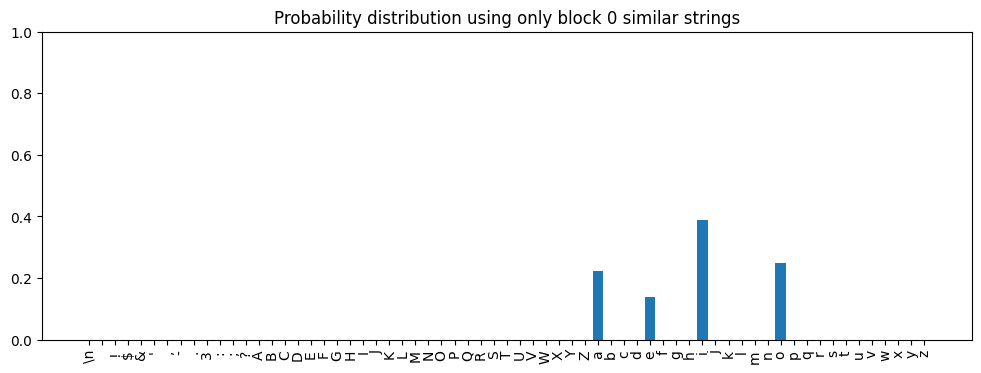

In [ ]:
plot_prob_distribution_for_tokens(prob_distribution, title='Probability distribution using only block 0 similar strings')

Let's compare this to what the model would have predicted for this prompt:

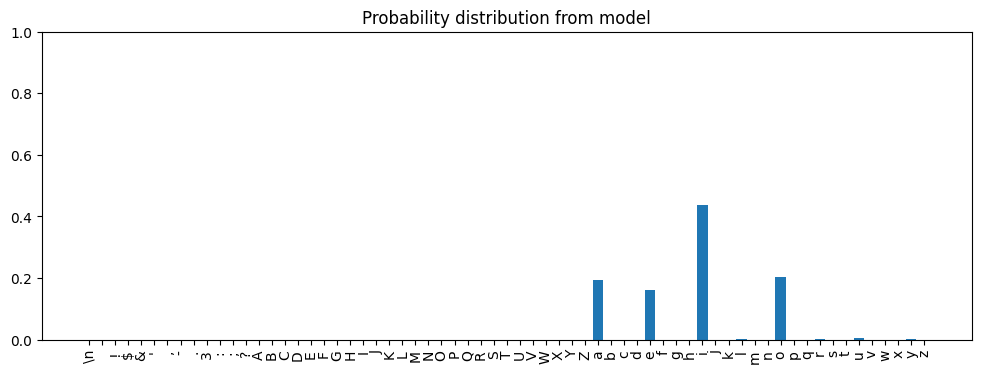

In [ ]:
tokens = encoding_helpers.tokenize_string(prompts[q_idx])
logits, _ = m(tokens)
logits = LogitsWrapper(logits.detach(), tokenizer)
logits.plot_probs(title='Probability distribution from model')

These already look very similar, and this is only using the similar strings for the first block. To better compare these, we can look at the distributions in text form:

In [ ]:
#| code-fold: true
#| code-summary: Helper function to print comparison of distributions as a table

def print_distribution_comparison(
    approx_top_tokens: Sequence[Tuple[str, float]],
    model_top_tokens: Sequence[Tuple[str, float]],
):
    max_len = min(len(approx_top_tokens), len(model_top_tokens))

    print(
        text_table(
            headers=["Model Predictions", "Approximation Predictions"],
            data_columns=[
                [
                    f"{repr(token)[1:-1]}: {prob:.3f}"
                    for i, (token, prob) in enumerate(model_top_tokens)
                    if i < max_len
                ],
                [
                    f"{repr(token)[1:-1]}: {prob:.3f}"
                    for i, (token, prob) in enumerate(approx_top_tokens)
                    if i < max_len
                ],
            ],
            col_widths=[20, 20],
        )
    )

In [ ]:
approx_top_tokens = top_nonzero_tokens(prob_distribution, tokenizer.itos)
model_top_tokens = logits.topk_tokens(k=10)[0][-1]

print_distribution_comparison(approx_top_tokens, model_top_tokens)

Model Predictions   Approximation Predictions
-----------------   -------------------------
i: 0.437            i: 0.389            
o: 0.204            o: 0.250            
a: 0.195            a: 0.222            
e: 0.160            e: 0.139            



Finally, we can also compare the Hellinger distance between these distributions:

In [ ]:
def hellinger_distance(
    p: torch.Tensor,
    q: torch.Tensor,
):
    return ((p.sqrt() - q.sqrt())**2).sum(dim=-1).sqrt() / math.sqrt(2)

In [ ]:
hellinger_distance(prob_distribution, logits.probs()[0][-1])

tensor(0.0711)

By combining the next token frequency distributions of the similar strings from just the first layer of the model, we are able to pretty closely approximate the output of the transformer. Of course, I chose an example that works particularly well. 

Here's an example where the frequency distribution from just the first layer doesn't work well:

In [ ]:
q_idx=40
prompts[q_idx]

'hing tremb'

In [ ]:
block_idx = 0
similarity_threshold=0.95
similar_indices = filter_on_prefiltered_results(
    load_prefiltered=lambda q_idx: load_prefiltered_data(block_idx, q_idx),
    q_idx_start=q_idx,
    q_idx_end=q_idx+1,
    filter_fn=lambda values: values > similarity_threshold
)
similar_strings = [
    [strings10[i] for i in indices]
    for indices in similar_indices
]
len(similar_strings[0])

57

In [ ]:
total_freq_distribution = torch.stack([
    next_token_map10[string] for string in similar_strings[0]
]).sum(dim=0)
prob_distribution = total_freq_distribution / total_freq_distribution.sum()

approx_top_tokens = top_nonzero_tokens(prob_distribution, tokenizer.itos)
model_top_tokens = logits.topk_tokens(k=10)[0][-1]

print_distribution_comparison(approx_top_tokens, model_top_tokens)

Model Predictions   Approximation Predictions
-----------------   -------------------------
l: 0.999            e: 0.543            
e: 0.000            l: 0.343            
r: 0.000            r: 0.114            



In [ ]:
tokens = encoding_helpers.tokenize_string(prompts[q_idx])
logits, _ = m(tokens)
logits = LogitsWrapper(logits.detach(), tokenizer)
hellinger_distance(prob_distribution, logits.probs()[0][-1])

tensor(0.6305)

For the prompt, `'hing tremb'`, we found 57 similar strings, but after building the probability distribution as we did before, we end up with something that looks quite different from what the model predicted and has a Hellinger distance of > 0.63.

As we'll see, this example, and several others, can be improved considering the feed-forward network outputs from the other blocks in building the approximation. 

### Similarity Thresholds

In the preceding examples, I used a similarity threshold of 0.95: I searched for strings whose feed-forward network outputs in block 0 produced values with a cosine similarity of 0.95 or greater when compared to the feed-forward network output of the prompt. 

If we'd used a different value, the results would have been different. For example, doing the same exercise for prompt id 57 (`'And only l'`) with a threshold of 0.90:

In [ ]:
block_idx = 0
similarity_threshold=0.90
q_idx = 57
similar_indices = filter_on_prefiltered_results(
    load_prefiltered=lambda q_idx: load_prefiltered_data(block_idx, q_idx),
    q_idx_start=q_idx,
    q_idx_end=q_idx+1,
    filter_fn=lambda values: values > similarity_threshold
)
similar_strings = [
    [strings10[i] for i in indices]
    for indices in similar_indices
]
len(similar_strings[0])

612

Now we find 612 similar strings, vs the 94 we had before. If we do the rest of the approximation procedure, we see different (and worse) results:

In [ ]:
total_freq_distribution = torch.stack([
    next_token_map10[string] for string in similar_strings[0]
]).sum(dim=0)
prob_distribution = total_freq_distribution / total_freq_distribution.sum()

approx_top_tokens = top_nonzero_tokens(prob_distribution, tokenizer.itos)
model_top_tokens = logits.topk_tokens(k=10)[0][-1]

print_distribution_comparison(approx_top_tokens, model_top_tokens)

Model Predictions   Approximation Predictions
-----------------   -------------------------
i: 0.437            o: 0.584            
o: 0.204            i: 0.251            
a: 0.195            a: 0.095            
e: 0.160            e: 0.066            
u: 0.004            u: 0.002            
l: 0.000            y: 0.001            



The top 5 tokens are the same, but when ranked by probability, the approximation has a different ordering than the model. The Hellinger distance is also higher:

In [ ]:
hellinger_distance(prob_distribution, logits.probs()[0][-1])

tensor(0.2856)

Loosening the similarity threshold introduced strings into the calculation that resulted in a worse approximation. Tightening beyond 0.95 also produces worse results, presumably because we're excluding strings that were needed to produce a good approximation:

In [ ]:
block_idx = 0
similarity_threshold=0.97
q_idx = 57
similar_indices = filter_on_prefiltered_results(
    load_prefiltered=lambda q_idx: load_prefiltered_data(block_idx, q_idx),
    q_idx_start=q_idx,
    q_idx_end=q_idx+1,
    filter_fn=lambda values: values > similarity_threshold
)
similar_strings = [
    [strings10[i] for i in indices]
    for indices in similar_indices
]
len(similar_strings[0])

33

In [ ]:

total_freq_distribution = torch.stack([
    next_token_map10[string] for string in similar_strings[0]
]).sum(dim=0)
prob_distribution = total_freq_distribution / total_freq_distribution.sum()

approx_top_tokens = top_nonzero_tokens(prob_distribution, tokenizer.itos)
model_top_tokens = logits.topk_tokens(k=10)[0][-1]

print_distribution_comparison(approx_top_tokens, model_top_tokens)

Model Predictions   Approximation Predictions
-----------------   -------------------------
i: 0.437            o: 0.278            
o: 0.204            i: 0.250            
a: 0.195            a: 0.250            
e: 0.160            e: 0.222            



In [ ]:
hellinger_distance(prob_distribution, logits.probs()[0][-1])

tensor(0.1498)

For the first block, 0.95 appears to be a sweet spot. I came up with this threshold through manual tuning: trying different values and binary searching towards one that produced the best results. The full history of this tuning exercise is in [this notebook](https://github.com/spather/transformer-experiments/blob/master/nbs/analyses/40_widening_similar_space.ipynb). 

In the end, I found the following thresholds produce the best results for each block:

| Block | Similarity Threshold |
|-------|----------------------|
| 0     | 0.95                 |
| 1     | 0.94                 |
| 2     | 0.85                 |
| 3     | 0.76                 |
| 4     | 0.81                 |
| 5     | 0.89                 |


>When I first started exploring this space, I assumed the approximation would get better if I could hone in on the most similar strings to the prompts. I tried a number of techniques including switching from Euclidean distance to cosine similarity, searching across strings of different lengths, etc. Every time I succeeded in finding more similar strings to use in the approximation, the results got worse. I realized that, at least for some blocks, including *less* similar strings in the mix produced better results.

### Going Beyond the First Block

Thus far, we've only considered feed-forward network outputs from the first block. Now we'll incorporate the feed-forward network outputs from the other blocks and look at how it affects the approximation.

First, let's compute the similar strings for each block, using the similarity thresholds listed above:

In [ ]:
similarity_thresholds=[0.95, 0.94, 0.85, 0.76, 0.81, 0.89]
q_idx = 57

similar_strings_per_block = []

for block_idx in range(n_layer):
    similar_indices = filter_on_prefiltered_results(
        load_prefiltered=lambda q_idx: load_prefiltered_data(block_idx, q_idx),
        q_idx_start=q_idx,
        q_idx_end=q_idx+1,
        filter_fn=lambda values: values > similarity_thresholds[block_idx]
    )
    similar_strings = [
        [strings10[i] for i in indices]
        for indices in similar_indices
    ]
    similar_strings_per_block.append(similar_strings)

And let's summarize how many we found for each block based on these thresholds:

In [ ]:
print(text_table(
    headers=["Block Index", "Similarity Threshold", "# of Similar Strings"],
    data_columns=[
        [f"{block_idx:>10}" for block_idx in range(n_layer)],
        [f"{threshold:>19}" for threshold in similarity_thresholds],
        [f"{len(similar_strings[0]):>19}" for similar_strings in similar_strings_per_block],
    ],
    col_widths=[14, 23, 23]
))


Block Index   Similarity Threshold   # of Similar Strings   
-----------   --------------------   --------------------   
         0                   0.95                     94    
         1                   0.94                     47    
         2                   0.85                     70    
         3                   0.76                    108    
         4                   0.81                    175    
         5                   0.89                   2237    



Now that we have all the similar strings for each block, we can do the next step of the approximation procedure: build the frequency distributions for the next tokens, and sum them up. We're going to be doing this several times over, so let's define a function for it:

In [ ]:
def frequency_distribution_from_similar_strings(
    similar_strings_per_block: Sequence[Sequence[Sequence[str]]],
    next_token_map: Dict[str, torch.Tensor],
) -> torch.Tensor:
    # freqs_per_block_per_query is a list of lists of tensors. The outer list has
    # one item per block. The inner list has one item per query. Each
    # tensor is the next token frequency distribution for a particular
    # block and query.
    freqs_per_block_per_query: List[List[torch.Tensor]] = [[] for _ in range(n_layer)]

    for block_idx in range(n_layer):
        for similar_strings in similar_strings_per_block[block_idx]:
            freqs_per_block_per_query[block_idx].append(
                torch.stack([next_token_map[string] for string in similar_strings]).sum(
                    dim=0
                )
            )

    # Stack all frequency tensors into a single tensor of shape
    # (n_layer, n_queries, vocab_size)
    freqs = torch.stack(
        [
            torch.stack(freqs_per_block_per_query[block_idx])
            for block_idx in range(n_layer)
        ]
    )

    return freqs

This function, `frequency_distribution_from_similar_strings()`, does the equivalent of this code we looked at earlier:

```python
total_freq_distribution = torch.stack([
    next_token_map10[string] for string in similar_strings[0]
]).sum(dim=0)
```

But with two key differences:

* It does this calculation for all the blocks, using the similar strings we found for each block above. 
* It allows for more than one query. In the code we've looked at so far, we only evaluated the approximation for a single prompt. In the next section, we'll be running it for lots of prompts so I've written the code in a more general form to a allow for this. Specifically, the code allows for `similar_strings_per_block` to contain not just a single list of similar strings per block but multiple: one for each query. 

Let's run this on the `similar_strings_per_block` we constructed earlier:

In [ ]:
freq_distribution = frequency_distribution_from_similar_strings(
    similar_strings_per_block,
    next_token_map10,
)
freq_distribution.shape

torch.Size([6, 1, 65])

It produces a tensor of shape `(6, 1, 65)`: 6 blocks, 1 query, 65 tokens in the vocabulary. If we'd been working with more queries, the middle dimension would be larger. 

So now we have a frequency distribution for each block, based on the similar strings found for each block using the similarity thresholds. We now need to turn this into a probability distribution.

Earlier, when we just had a single frequency distribution for a single block, we just normalized it. But now we have multiple frequency distributions and need to combine them. In my experiments, I found that a weighted sum of these distributions produced the best results. 

As with the similarity thresholds, I was able to find a set of good weights by trial and error. I also tried a deep-learning approach to find weights, which I'll describe layer. The procedure for both hand-tuning and learning weights is implemented in [the same notebook](https://github.com/spather/transformer-experiments/blob/master/nbs/analyses/40_widening_similar_space.ipynb) used for tuning thresholds. 

For now, let's use the optimal weights I found:

In [ ]:
weights = torch.tensor([0.01, 0.01, 0.1, 1.5, 6, 0.01]).unsqueeze(dim=1).unsqueeze(dim=2) # (n_layer, 1, 1)
total_freq_distribution = (freq_distribution * weights).sum(dim=0)
prob_distribution = total_freq_distribution / total_freq_distribution.sum(dim=-1, keepdim=True)


We multiply the frequency distributions by the weights, sum across all blocks, and then normalize into a probability distribution. We can now look at how the approximation's distribution compares to the model's.

> Note: in the code below, we have to index into the `prob_distribution` tensor with `[0]` because its first dimension is the number of queries. We're only working with a single query, so we can just take the first element.

In [ ]:
approx_top_tokens = top_nonzero_tokens(prob_distribution[0], tokenizer.itos)
model_top_tokens = logits.topk_tokens(k=10)[0][-1]

print_distribution_comparison(approx_top_tokens, model_top_tokens)

Model Predictions   Approximation Predictions
-----------------   -------------------------
i: 0.437            i: 0.363            
o: 0.204            o: 0.265            
a: 0.195            a: 0.213            
e: 0.160            e: 0.147            
u: 0.004            u: 0.011            
l: 0.000            y: 0.000            



In [ ]:
hellinger_distance(prob_distribution[0], logits.probs()[0][-1])

tensor(0.0731)

In this particular case, adding the other layers didn't change the approximation much (if anything, it's very slightly worse based on Hellinger distance). But let's look at the example that didn't work well when we considered just the first layer: prompt id 40 (`'hing tremb'`). 

In [ ]:
similarity_thresholds=[0.95, 0.94, 0.85, 0.76, 0.81, 0.89]
q_idx = 40

similar_strings_per_block = []

for block_idx in range(n_layer):
    similar_indices = filter_on_prefiltered_results(
        load_prefiltered=lambda q_idx: load_prefiltered_data(block_idx, q_idx),
        q_idx_start=q_idx,
        q_idx_end=q_idx+1,
        filter_fn=lambda values: values > similarity_thresholds[block_idx]
    )
    similar_strings = [
        [strings10[i] for i in indices]
        for indices in similar_indices
    ]
    similar_strings_per_block.append(similar_strings)

freq_distribution = frequency_distribution_from_similar_strings(
    similar_strings_per_block,
    next_token_map10,
)
weights = torch.tensor([0.01, 0.01, 0.1, 1.5, 6, 0.01]).unsqueeze(dim=1).unsqueeze(dim=2) # (n_layer, 1, 1)
total_freq_distribution = (freq_distribution * weights).sum(dim=0)
prob_distribution = total_freq_distribution / total_freq_distribution.sum(dim=-1, keepdim=True)
tokens = encoding_helpers.tokenize_string(prompts[q_idx])
logits, _ = m(tokens)
logits = LogitsWrapper(logits.detach(), tokenizer)

approx_top_tokens = top_nonzero_tokens(prob_distribution[0], tokenizer.itos)
model_top_tokens = logits.topk_tokens(k=10)[0][-1]

print_distribution_comparison(approx_top_tokens, model_top_tokens)

Model Predictions   Approximation Predictions
-----------------   -------------------------
l: 0.999            l: 0.997            
e: 0.000            e: 0.002            
r: 0.000            r: 0.000            



In [ ]:
hellinger_distance(prob_distribution, logits.probs()[0][-1])

tensor([0.0233])

Remember that for this example, when we used just the first layer's similar strings, the approximation was quite different from the model's prediction and had a Hellinger distance of > 0.63. Now it's nearly identical and has a Hellinger distance of 0.02. 

So using the rest of the layers really helped this example. In the next section, we'll evaluate the approximation in aggregate, over the whole set of 20,000 prompts. 

### Aggregate Performance


We now have all the building blocks in place to run the approximation procedure for all 20,000 prompts, using the feed-forward network outputs of all 6 layers. Let's do that and look at the results.

First, let's find the similar strings for all the prompts, for all blocks:

In [ ]:
# Takes about 7 minutes to run

similarity_thresholds=[0.95, 0.94, 0.85, 0.76, 0.81, 0.89]

similar_strings_per_block = []

for block_idx in range(n_layer):
    similar_indices = filter_on_prefiltered_results(
        load_prefiltered=lambda q_idx: load_prefiltered_data(block_idx, q_idx),
        q_idx_start=0,
        q_idx_end=n_prompts,
        filter_fn=lambda values: values > similarity_thresholds[block_idx]
    )
    similar_strings = [
        [strings10[i] for i in indices]
        for indices in similar_indices
    ]
    similar_strings_per_block.append(similar_strings)

In [ ]:
#| hide
# Because the similar strings per block takes about 7 minutes to generate,
# save it so we can quickly re-load it if needed:

# Create directory in which to save similar strings file

artifact_path = environment.data_root / "blog_posts_artifacts/block_internals/"
artifact_path.mkdir(exist_ok=True, parents=True)

In [ ]:
#| hide

# Save the similar strings per block
(artifact_path/'similar_strings_per_block.json').write_text(
    json.dumps(similar_strings_per_block, indent=2)
)


2936811909

In [ ]:
#| hide

# Load similar strings per block from saved data
similar_strings_per_block = json.loads((artifact_path/'similar_strings_per_block.json').read_text())

Next, we compute the frequency distributions for each query based on the similar strings, perform the weighted sum, and normalize to produce a probability distribution.

In [ ]:
freq_distribution = frequency_distribution_from_similar_strings(
    similar_strings_per_block,
    next_token_map10,
)
weights = torch.tensor([0.01, 0.01, 0.1, 1.5, 6, 0.01]).unsqueeze(dim=1).unsqueeze(dim=2) # (n_layer, 1, 1)
total_freq_distribution = (freq_distribution * weights).sum(dim=0)
prob_distribution = total_freq_distribution / total_freq_distribution.sum(dim=-1, keepdim=True)
prob_distribution.shape

torch.Size([20000, 65])

In order to compare, we need to run all the prompts through the model and get the output probability distributions the model predicts:

In [ ]:
tokens = encoding_helpers.tokenize_strings(prompts)
logits, _ = m(tokens)
logits = LogitsWrapper(logits.detach(), tokenizer)
model_probs = logits.probs()
model_probs = model_probs[:, -1, :] # We're only interested in the last token

Now we can compute the Hellinger distance between the approximation and the model's prediction for each prompt:

In [ ]:
h = hellinger_distance(prob_distribution, model_probs)
h.shape

torch.Size([20000])

This produced 20,000 Hellinger distance scores, one for each prompt. We can start by looking at some basic stats:

In [ ]:
h.mean(), h.std(), h.min(), h.max()

(tensor(0.1677), tensor(0.1215), tensor(0.0013), tensor(0.9994))

The average Hellinger distance is just below 0.17, with a standard deviation of around 0.12, suggesting a distribution that skews low (a good thing). We've also got at least one really excellent sample (a min of 0.0013) and at least one really terrible one (max of 0.9994). 

Let's look at the distribution:

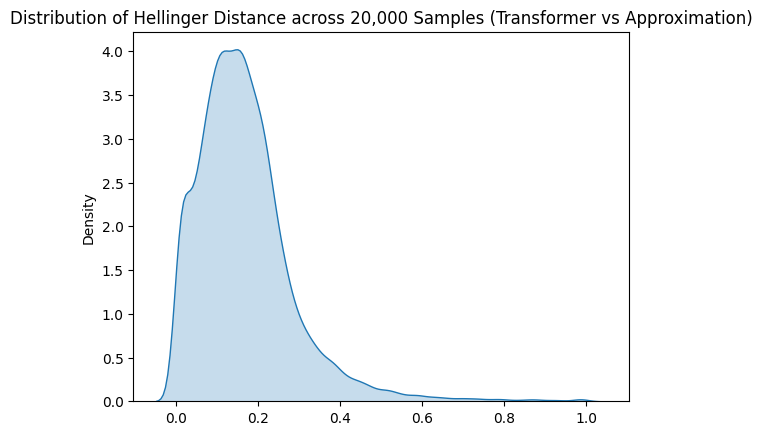

In [ ]:
sns.kdeplot(h.numpy(), fill=True)
plt.title("Distribution of Hellinger Distance across 20,000 Samples (Transformer vs Approximation)")
plt.show()

Indeed, the distribution is skewed left, indicating most queries have Hellinger distance scores on the lower end. 

But is this a good performance good? It's hard to say without something to compare against. 

One guidepost is to compare to another transformer model. I trained the same transformer architecture again on the same data set, starting from a different random seed and stopping at about the same training and validation loss. I ran the same 20,000 prompts through the alternative model and calculated the Hellinger distance between its predictions and the original model's predictions:

TODO: Train a few more models with different seeds to about the same loss and see how the results compare.

In [ ]:
m_alt, _ = create_model_and_tokenizer(
    saved_model_filename=environment.code_root / 'nbs/artifacts/shakespeare-20231109.pt',
    dataset=ts,
    device=device,
)

logits_alt, _ = m_alt(tokens)
logits_alt = LogitsWrapper(logits_alt.detach(), tokenizer)
model_probs_alt = logits_alt.probs()
model_probs_alt = model_probs_alt[:, -1, :] # We're only interested in the last token


In [ ]:
h_alt = hellinger_distance(model_probs, model_probs_alt)

In [ ]:
h_alt.mean(), h_alt.std(), h_alt.min(), h_alt.max()

(tensor(0.1227), tensor(0.0932), tensor(0.0008), tensor(0.9069))

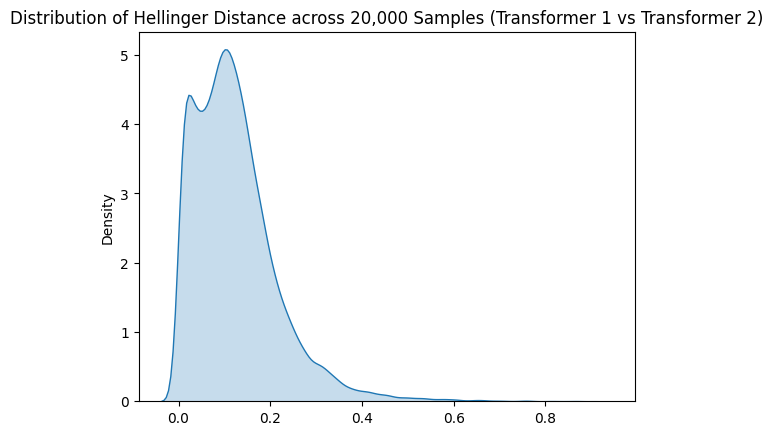

In [ ]:
sns.kdeplot(h_alt.numpy(), fill=True)
plt.title("Distribution of Hellinger Distance across 20,000 Samples (Transformer 1 vs Transformer 2)")
plt.show()

There is clearly less deviation between the two transformers than between the approximation and the transformer, but it's not wildly different. The average Hellinger distance between the approximation and the transformer is within one standard deviation of the average Hellinger distance between the two transformers.